We want to compute intra and inter network connectivty from covariance matrices, which should have been computed in `compare_maps.ipynb`

In [44]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import itertools

import joblib
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.connectivity import reshape_pvalues, network_to_network_connectivity, block_block
from bold_dementia.connectivity.matrices import plot_matrix, group_by_networks
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.histograms import fast_hist
from bold_dementia.utils.iterables import unique, itersize

ATLAS = "msdl"
SOFT = True
matrices_path = Path(
    f"{config['connectivity_matrices']}/atlas-{ATLAS}_default"
)

In [45]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")

n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

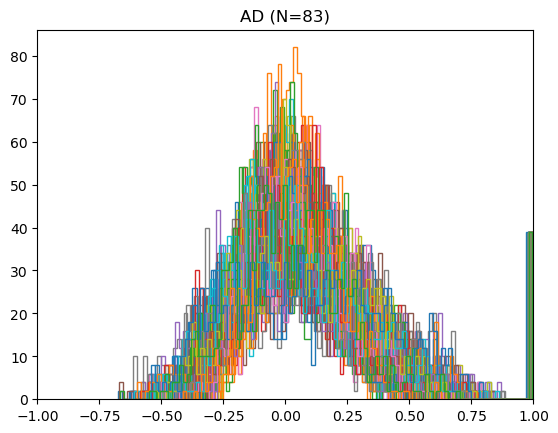

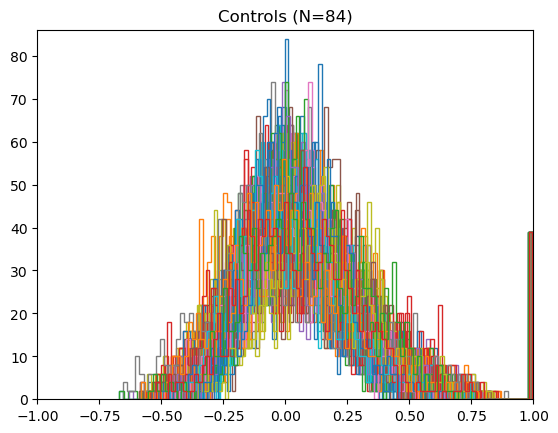

In [46]:
_, ax = fast_hist(AD_matrices, bins=100) 
ax.set_title(f"AD (N={n_AD})")
plt.show()

control_subsampled = control_matrices[::(n_controls//n_AD), :, :]
fig, ax2 = fast_hist(control_subsampled, bins=100) 
ax2.set_ylim(ax.get_ylim())
ax2.set_title(f"Controls (N={control_subsampled.shape[0]})")

plt.show()

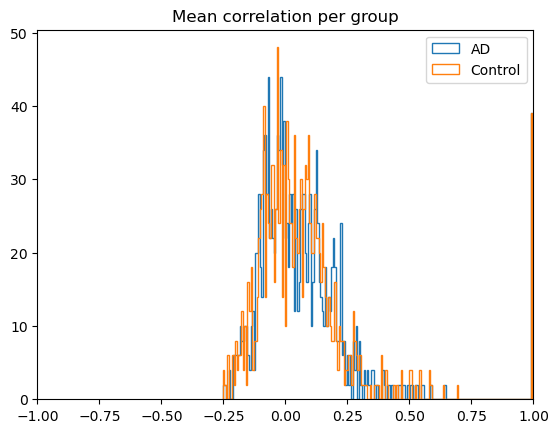

In [47]:
plt.hist(AD_matrices.mean(axis=0).flatten(), histtype="step", label="AD", bins=200)
plt.hist(control_matrices.mean(axis=0).flatten(), histtype="step", label="Control", bins=200)
plt.xlim(-1, 1)
plt.legend()
plt.title("Mean correlation per group")
plt.show()

In [48]:
ticks, sort_index = group_by_networks(atlas.macro_labels)

matrix_sort = np.ix_(sort_index, sort_index)
AD = AD_matrices.mean(axis=0)[matrix_sort]
control = control_matrices.mean(axis=0)[matrix_sort]


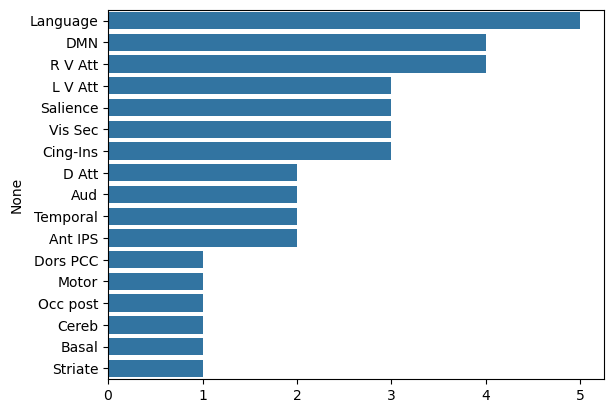

In [49]:

names, counts = np.unique(np.array(atlas.macro_labels), return_counts=True)
s = pd.Series(dict(zip(tuple(names), tuple(counts)))).sort_values(ascending=False)
sns.barplot(y=s.index, x=s.values)
plt.show()


In [50]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))

network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Ant IPS       (0, 2)
Aud           (2, 4)
Basal         (4, 5)
Cereb         (5, 6)
Cing-Ins      (6, 9)
D Att        (9, 11)
DMN         (11, 15)
Dors PCC    (15, 16)
L V Att     (16, 19)
Language    (19, 24)
Motor       (24, 25)
Occ post    (25, 26)
R V Att     (26, 30)
Salience    (30, 33)
Striate     (33, 34)
Temporal    (34, 36)
Vis Sec     (36, 39)
dtype: object

In [64]:
from itertools import product

def mean_connectivity(block):
    return (np.mean(block),)


In [65]:
def macro_matrix(matrix, network_to_idx):
    gen = block_block(matrix, network_to_idx, aggregating_func=mean_connectivity)
    comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "connectivity"])
    pivoted = comparisons.pivot(index="node_a", columns="node_b")
    return pivoted.loc[:, "connectivity"]
    

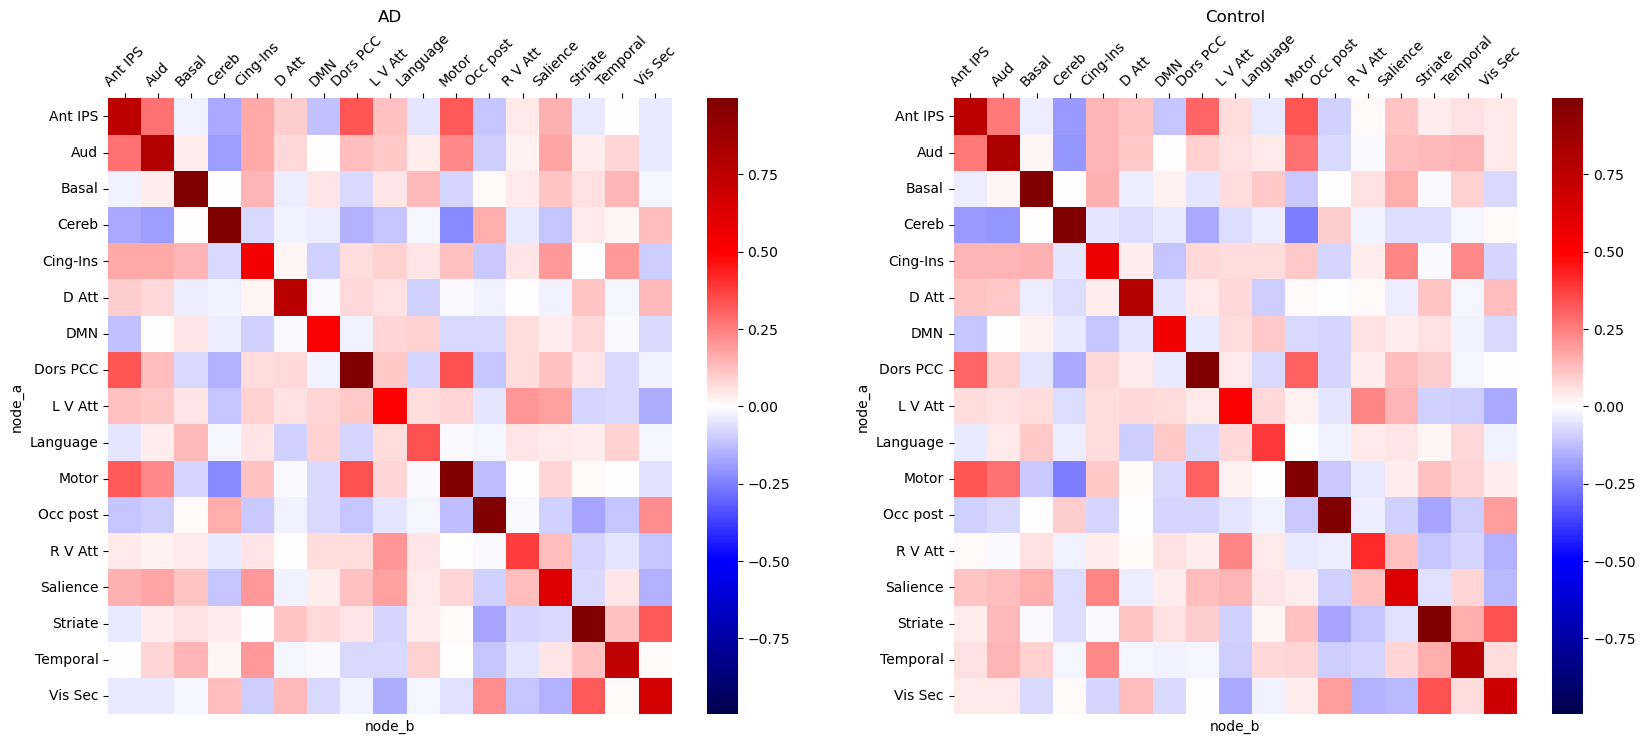

In [66]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

spanfunc = lambda arr: np.max(np.abs(arr))


macro_control = macro_matrix(control, network_to_idx)
macro_AD = macro_matrix(AD, network_to_idx)
span = max(spanfunc(macro_AD), spanfunc(macro_control))


heat_kwargs = {"vmin": -span, "vmax":span, "cmap":"seismic", "xticklabels":unique_m, "yticklabels":unique_m}

sns.heatmap(macro_AD, ax=ax1, **heat_kwargs)

sns.heatmap(macro_control, ax=ax2, **heat_kwargs)

ax1.tick_params(axis="x", labelrotation=45)
ax1.xaxis.tick_top()
ax1.set_title("AD")
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title("Control")
ax2.xaxis.tick_top()

plt.show()

Text(0.5, 1.0, 'msdl AD - control')

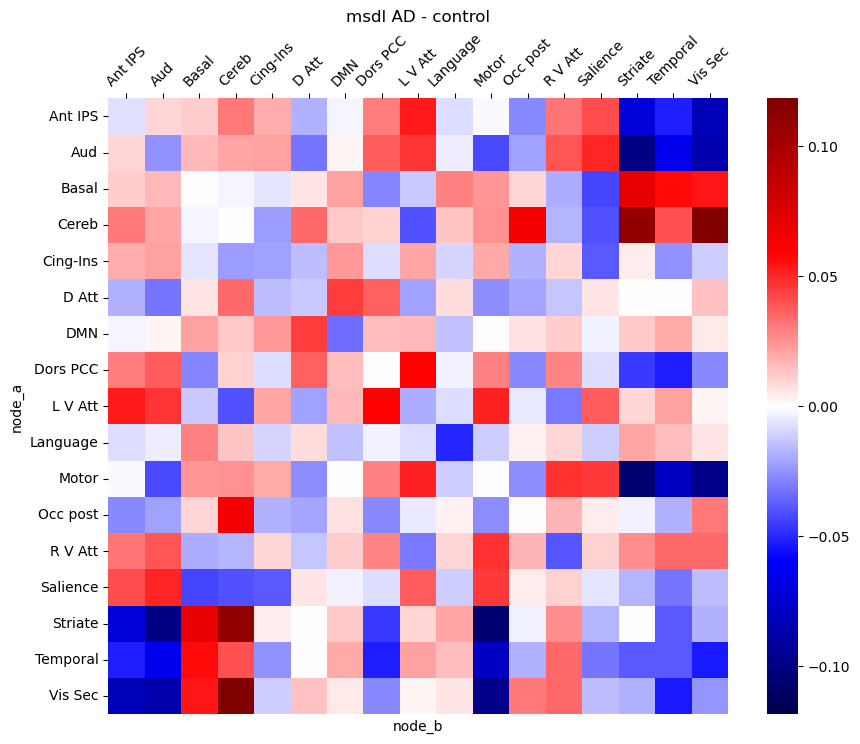

In [67]:
diff = macro_AD - macro_control
dspan = np.max(abs(diff))

try:
    heat_kwargs.pop("vmin")
    heat_kwargs.pop("vmax")
except KeyError:
    pass

plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(diff, vmin=-dspan, vmax=dspan, **heat_kwargs)
ax.xaxis.tick_top()
ax.tick_params(axis="x", labelrotation=45)
ax.set_title(f"{ATLAS} AD - control")